Flex all X-axes joints of the robox.

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [43]:
import os, sys, time
from os.path import dirname
sys.path.append(os.path.join(os.getcwd(), '..'))

In [3]:
import cv2
import pybullet as p
import numpy as np
import pylab

from opencv.opencv_tools import save
from pyb.pybullet_robot import PyBulletRobot
from opencv.opencv_pose import Pose
from phy.phy_robot import PhyRobot

In [122]:
vr = PyBulletRobot(render=False)

*** Initializing PyBulletRobot(ns=4, render=False) ...
*** Initializing PyBulletRobot() done


In [123]:
def phis_1x(phix):
    phis = np.array([[phix, 0], [phix, 0], [phix, 0], [phix, 0]])
    return phis

def vr_sweep(phixs):
    phiss, camps, tvecs, rvecs = [], [], [], []

    first_phi, last_phi = None, None
    vpose = Pose(vr.W, vr.H, '../pyb/cal.npz', vr.D)

    for phix in phixs:
        phis = phis_1x(phix)                  
        vr.step(phis)
        img, cam_p, _, _, _ = vr.getHeadcam()
        retval, rvec, tvec, _ = vpose.findChessboardRTVecs(img)
        if retval:
            camps.append(cam_p)
            tvecs.append(tvec)
            rvecs.append(rvec)
            phiss.append(phis)

            if first_phi is None:
                first_phi = last_phi = phix
                print("vr first_phi: %f" % first_phi)
            elif last_phi < phix:
                last_phi = phix

            evec = rodrigues_to_euler_angles(rvec)
            print("evec1=%s" % evec[1])
            if evec[1] > 0:
                break

    print("vr last_phi: %f" % last_phi)

    phiss = np.array(phiss)
    camps = np.array(camps)
    rvecs = np.array(rvecs)
    tvecs = np.array(tvecs)

    return phiss, camps, tvecs, rvecs

In [124]:
PHIX_LOW, PHIX_HIGH = np.pi/12, np.pi/6
DPHI = (PHIX_HIGH - PHIX_LOW) / 25
phixs = np.arange(PHIX_LOW, PHIX_HIGH+DPHI, DPHI)

## VR robot

In [125]:
phiss, camps, tvecs, rvecs = vr_sweep(phixs)

# distance from damera position to the center of the chessboard
camds = []
for cam_p in camps:
    cam_d = np.sqrt(np.sum(np.square(np.array(cam_p) - np.array([2, 0, 0.59])), axis=0))
    camds.append(cam_d)
camds = np.array(camds)

# length of the translation vector
tvecds = np.sqrt(np.sum(np.square(tvecs), axis=1)).ravel()

vr first_phi: 0.324631
evec1=-0.27080263449122716
evec1=-0.22855397851933146
evec1=-0.1801115251499779
evec1=-0.153278808275687
evec1=-0.10383547100287387
evec1=-0.05728686457338606
evec1=-0.033300397596142194
evec1=0.008019785045588852
vr last_phi: 0.397935


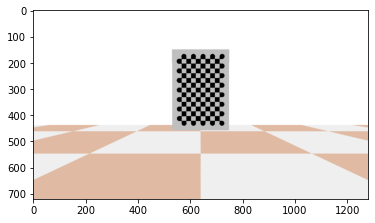

In [126]:
img, _, _, _, _ = vr.getHeadcam()
plt.imshow(img)

#### head moves down on Z world axis

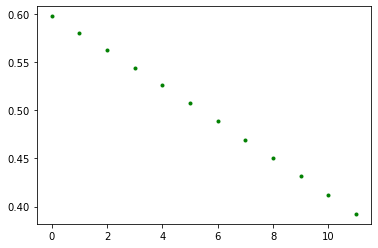

In [13]:
plt.plot(camps[:,2], 'g.')

#### target Y component of translation vector sweeps from 0.6 to -0.6

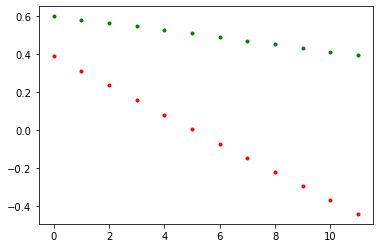

In [14]:
plt.plot(camps[:,2], 'g.', tvecs[:,1], 'r.')

#### headcam sways horizontally a tiny bit

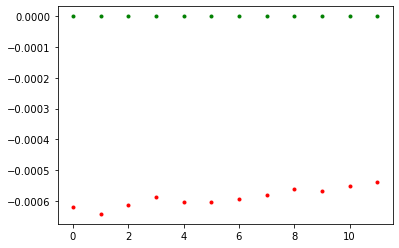

In [15]:
plt.plot(camps[:,1], 'g.', tvecs[:,0], 'r.')

#### headcam gets closer to the target

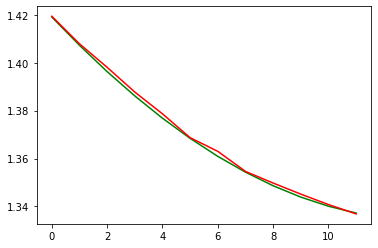

In [16]:
plt.plot(camds, 'g', tvecds, 'r')

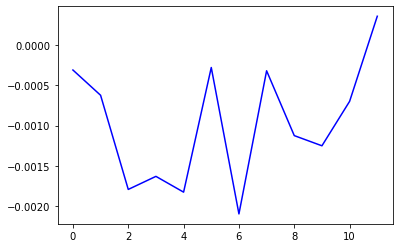

In [17]:
plt.plot(camds - tvecds, 'b')

####  Z component of translation vector reaches it peak and goes away

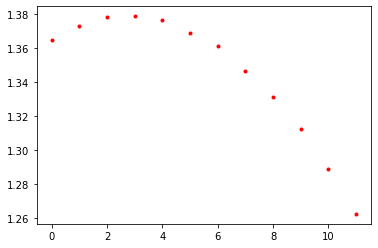

In [18]:
plt.plot(tvecs[:,2], 'r.')

#### Rotation vectors

In [19]:
def rodrigues_to_euler_angles(rvec):
        mat, jac = cv2.Rodrigues(rvec)

        sy = np.sqrt(mat[0, 0] * mat[0, 0] + mat[1, 0] * mat[1, 0])

        singular = sy < 1e-6

        if not singular:
            x = np.math.atan2(mat[2, 1], mat[2, 2])
            y = np.math.atan2(-mat[2, 0], sy)
            z = np.math.atan2(mat[1, 0], mat[0, 0])

        else:
            x = np.math.atan2(-mat[1, 2], mat[1, 1])
            y = np.math.atan2(-mat[2, 0], sy)
            z = 0

        return np.array([x, y, z])

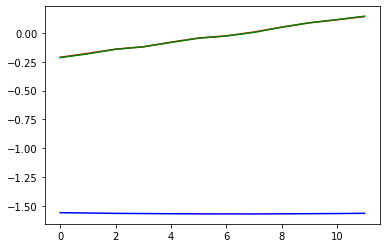

In [20]:
_ = plt.plot(rvecs[:,0], 'r', rvecs[:,1], 'g', rvecs[:,2], 'b', )

In [21]:
evecs=[]
for rvec in rvecs:
    evec = rodrigues_to_euler_angles(rvec)
    evecs.append(evec)
evecs=np.array(evecs)

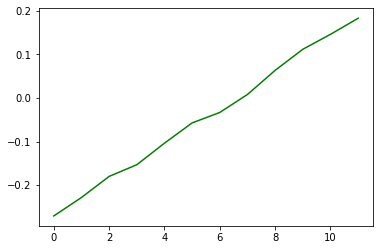

In [28]:
#_ = plt.plot(evecs[:,0], 'r', evecs[:,1], 'g', evecs[:,2], 'b', )
_ = plt.plot(evecs[:,1], 'g')

In [23]:
vr.close()

*** PyBulletRobot() closed ***


## Real Robot

In [4]:
rr = PhyRobot()

# ==== 
# COMPORT 1 port=COM3 desc=Arduino Mega 2560 (COM3) hwid=USB VID:PID=2341:0042 SER=5583834363335110D111 LOCATION=1-1.2
# + IDENTIFIED AS PORT2: COM3
# COMPORT 2 port=COM4 desc=Arduino Mega 2560 (COM4) hwid=USB VID:PID=2341:0042 SER=858303033393515190B0 LOCATION=1-1.1
# + IDENTIFIED AS PORT1: COM4
# + Found PORT1=COM4 PORT2=COM3
Current resolution: 640.0x480.0
New resolution: 1920.0x1080.0


In [98]:
phixs = np.arange(0.22, 0.31, 0.002)
phixs.shape

(55,)

In [111]:
def rr_sweep(phixs):
    phiss, tvecs, rvecs = [], [], []

    PHIX_LOW, PHIX_HIGH = np.pi/12, np.pi/6
    DPHI = (PHIX_HIGH - PHIX_LOW) / 25

    first_phi, last_phi = None, None
    vpose = Pose(rr.W, rr.H, '../phy/cal.npz', rr.D)

    first = True
    for phix in phixs:
        print("phix=%s" % phix)
        phis = phis_1x(phix)                  
        rr.step(phis)
        
        if first:
            time.sleep(5)
            first = False
        else:
            time.sleep(1)
        
        img, _, _, _, _ = rr.getHeadcam()
        retval, rvec, tvec, _ = vpose.findChessboardRTVecs(img)
        if retval:
            phiss.append(phis)
            rvecs.append(rvec)
            tvecs.append(tvec)

            if first_phi is None:
                first_phi = last_phi = phix
                print("rr first_phi: %f" % first_phi)
            elif last_phi < phix:
                last_phi = phix
                
            evec = rodrigues_to_euler_angles(rvec)
            print("evec1=%s" % evec[1])
            if evec[1] > 0:
                break

    print("rr last_phi: %s" % last_phi)

    phiss = np.array(phiss)
    rvecs = np.array(rvecs)
    tvecs = np.array(tvecs)

    return phiss, tvecs, rvecs

In [112]:
r_phiss, r_tvecs, r_rvecs = rr_sweep(phixs)
r_tvecds = np.sqrt(np.sum(np.square(r_tvecs), axis=1)).ravel()

phix=0.2
phix=0.202
phix=0.20400000000000001
phix=0.20600000000000002
phix=0.20800000000000002
phix=0.21000000000000002
phix=0.21200000000000002
phix=0.21400000000000002
phix=0.21600000000000003
phix=0.21800000000000003
phix=0.22000000000000003
phix=0.22200000000000003
phix=0.22400000000000003
phix=0.22600000000000003
phix=0.22800000000000004
phix=0.23000000000000004
phix=0.23200000000000004
phix=0.23400000000000004
phix=0.23600000000000004
phix=0.23800000000000004
phix=0.24000000000000005
phix=0.24200000000000005
phix=0.24400000000000005
phix=0.24600000000000005
phix=0.24800000000000005
phix=0.25000000000000006
rr first_phi: 0.250000
evec1=-0.1558322807491588
phix=0.25200000000000006
evec1=-0.15129863078380773
phix=0.25400000000000006
evec1=-0.1436108602008589
phix=0.25600000000000006
evec1=-0.13776586552813913
phix=0.25800000000000006
evec1=-0.1319049311787152
phix=0.26000000000000006
evec1=-0.12466826796464525
phix=0.26200000000000007
evec1=-0.1178261344332967
phix=0.264000000000000

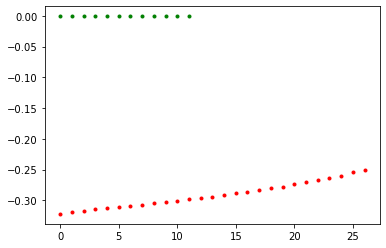

In [100]:
plt.plot(tvecs[:,0], 'g.', r_tvecs[:,0], 'r.')

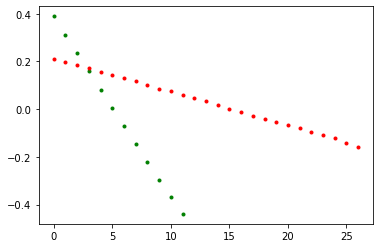

In [101]:
plt.plot(tvecs[:,1], 'g.', r_tvecs[:,1], 'r.')

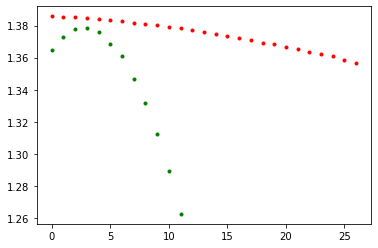

In [102]:
plt.plot(tvecs[:,2], 'g.', r_tvecs[:,2], 'r.')

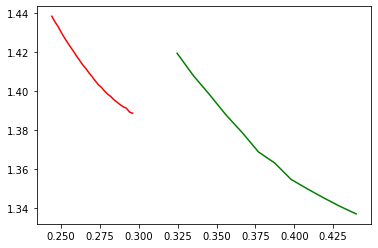

In [103]:
plt.plot(phiss[:,0,0], tvecds, 'g', r_phiss[:,0,0], r_tvecds, 'r', )

In [104]:
r_evecs=[]
for rvec in r_rvecs:
    evec = rodrigues_to_euler_angles(rvec)
    r_evecs.append(evec)
r_evecs=np.array(r_evecs)

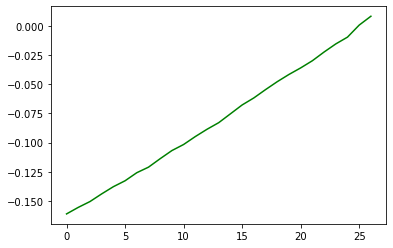

In [106]:
#_ = plt.plot(r_evecs[:,0], 'r', r_evecs[:,1], 'g', r_evecs[:,2], 'b', )
_ = plt.plot(r_evecs[:,1], 'g')

In [108]:
rr.home()

In [114]:
img, _, _, _, _ = rr.getHeadcam()

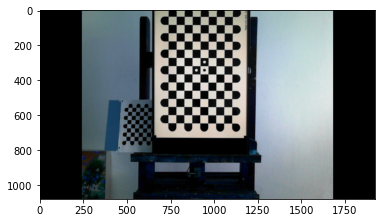

In [115]:
plt.imshow(img)

In [116]:
r_evecs[-1]

array([-0.01844609,  0.00838393, -1.55313298])

In [117]:
r_tvecds[-1]

1.388563981132566

In [118]:
phiss[-1]

array([[0.43982297, 0.        ],
       [0.43982297, 0.        ],
       [0.43982297, 0.        ],
       [0.43982297, 0.        ]])